# Sentiment Analysis using BERT
This notebook performs sentiment analysis using a pre-trained BERT model. The process includes data preprocessing, tokenization, model fine-tuning, evaluation, and plotting training and validation metrics.

In [1]:
# Install required libraries
!pip install transformers torch scikit-learn pandas matplotlib

In [2]:
# Import required libraries
import pandas as pd
import torch
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from transformers import BertTokenizer, BertForSequenceClassification
from torch.utils.data import Dataset, DataLoader
from transformers import AdamW, get_scheduler
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report

In [3]:
# Load the uploaded CSV file to inspect its structure and content
file_path = '/content/reviews.csv'
reviews_data = pd.read_csv(file_path)

# Display basic information about the dataset
reviews_data.info(), reviews_data.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12495 entries, 0 to 12494
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   reviewId              12495 non-null  object
 1   userName              12495 non-null  object
 2   userImage             12495 non-null  object
 3   content               12495 non-null  object
 4   score                 12495 non-null  int64 
 5   thumbsUpCount         12495 non-null  int64 
 6   reviewCreatedVersion  10333 non-null  object
 7   at                    12495 non-null  object
 8   replyContent          5818 non-null   object
 9   repliedAt             5818 non-null   object
 10  sortOrder             12495 non-null  object
 11  appId                 12495 non-null  object
dtypes: int64(2), object(10)
memory usage: 1.1+ MB


(None,
                                             reviewId  \
 0  gp:AOqpTOEhZuqSqqWnaKRgv-9ABYdajFUB0WugPGh-SG-...   
 1  gp:AOqpTOH0WP4IQKBZ2LrdNmFy_YmpPCVrV3diEU9KGm3...   
 2  gp:AOqpTOEMCkJB8Iq1p-r9dPwnSYadA5BkPWTf32Z1azu...   
 3  gp:AOqpTOGFrUWuKGycpje8kszj3uwHN6tU_fd4gLVFy9z...   
 4  gp:AOqpTOHls7DW8wmDFzTkHwxuqFkdNQtKHmO6Pt9jhZE...   
 
                            userName  \
 0                          Eric Tie   
 1                        john alpha   
 2                       Sudhakar .S   
 3  SKGflorida@bellsouth.net DAVID S   
 4                     Louann Stoker   
 
                                            userImage  \
 0  https://play-lh.googleusercontent.com/a-/AOh14...   
 1  https://play-lh.googleusercontent.com/a-/AOh14...   
 2  https://play-lh.googleusercontent.com/a-/AOh14...   
 3  https://play-lh.googleusercontent.com/-75aK0WF...   
 4  https://play-lh.googleusercontent.com/-pBcY_Z-...   
 
                                              content  score  t

In [5]:
# Step 1: Data Cleaning and Preprocessing
# Convert 'at' and 'repliedAt' columns to datetime format
reviews_data['at'] = pd.to_datetime(reviews_data['at'], errors='coerce')
reviews_data['repliedAt'] = pd.to_datetime(reviews_data['repliedAt'], errors='coerce')

# Fill missing values in 'reviewCreatedVersion' with 'Unknown'
reviews_data['reviewCreatedVersion'] = reviews_data['reviewCreatedVersion'].fillna('Unknown')

# Fill missing values in 'replyContent' with an empty string
reviews_data['replyContent'] = reviews_data['replyContent'].fillna('')

# Add a new column 'reviewLength' to measure the length of each review content
reviews_data['reviewLength'] = reviews_data['content'].apply(len)

# Display summary statistics to understand distributions
summary_stats = reviews_data.describe(include='all')

# Generate basic EDA insights like score distribution and review length distribution
score_distribution = reviews_data['score'].value_counts().sort_index()
review_length_distribution = reviews_data['reviewLength'].describe()

# Display EDA insights to the user
summary_stats, score_distribution, review_length_distribution

(                                                 reviewId       userName  \
 count                                               12495          12495   
 unique                                              12495          11967   
 top     gp:AOqpTOEhZuqSqqWnaKRgv-9ABYdajFUB0WugPGh-SG-...  A Google user   
 freq                                                    1            260   
 mean                                                  NaN            NaN   
 min                                                   NaN            NaN   
 25%                                                   NaN            NaN   
 50%                                                   NaN            NaN   
 75%                                                   NaN            NaN   
 max                                                   NaN            NaN   
 std                                                   NaN            NaN   
 
                                                 userImage content  \
 cou

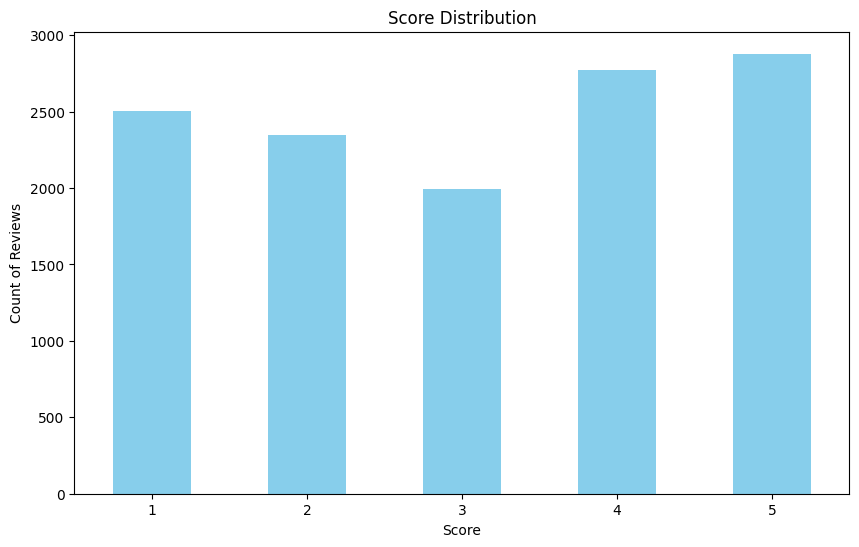

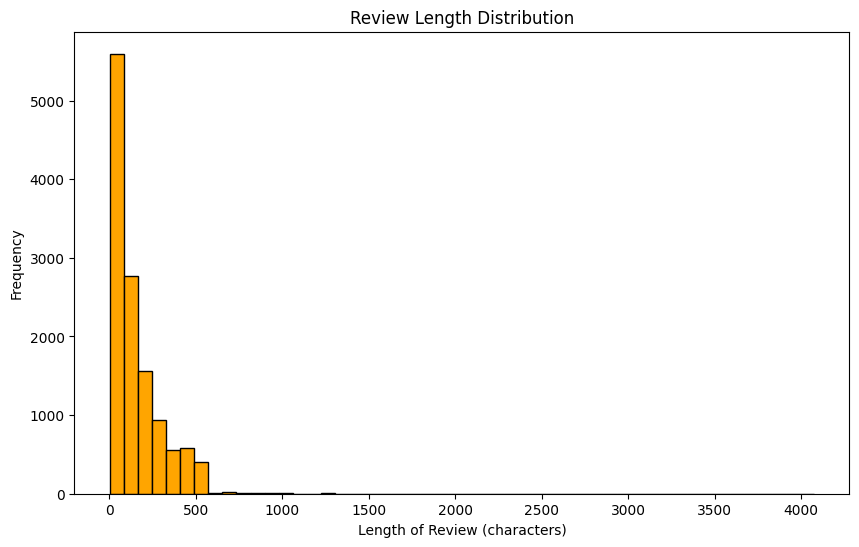

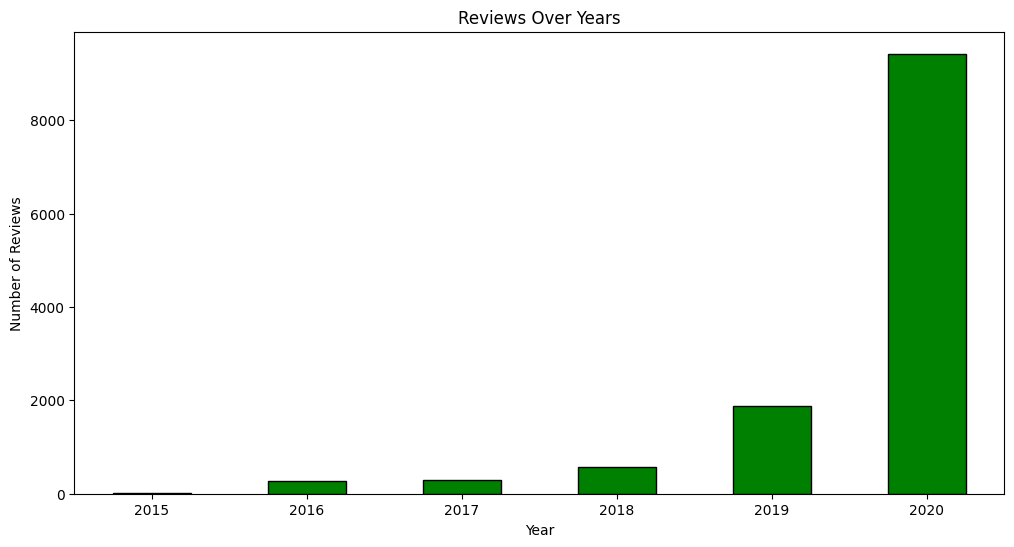

In [6]:
# Score distribution plot
plt.figure(figsize=(10, 6))
score_distribution.sort_index().plot(kind='bar', color='skyblue')
plt.title('Score Distribution')
plt.xlabel('Score')
plt.ylabel('Count of Reviews')
plt.xticks(rotation=0)
plt.show()

# Review length distribution histogram
plt.figure(figsize=(10, 6))
plt.hist(reviews_data['reviewLength'], bins=50, color='orange', edgecolor='black')
plt.title('Review Length Distribution')
plt.xlabel('Length of Review (characters)')
plt.ylabel('Frequency')
plt.show()

# Temporal distribution of reviews
plt.figure(figsize=(12, 6))
reviews_data['at'].dt.year.value_counts().sort_index().plot(kind='bar', color='green', edgecolor='black')
plt.title('Reviews Over Years')
plt.xlabel('Year')
plt.ylabel('Number of Reviews')
plt.xticks(rotation=0)
plt.show()

In [7]:
# Define sentiment categories
def categorize_sentiment(score):
    if score in [1, 2]:
        return 'Negative'
    elif score == 3:
        return 'Neutral'
    else:
        return 'Positive'

reviews_data['sentiment'] = reviews_data['score'].apply(categorize_sentiment)

In [8]:
# Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(
    reviews_data['content'], reviews_data['sentiment'], test_size=0.2, random_state=42, stratify=reviews_data['sentiment']
)

In [9]:
# Initialize BERT tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Tokenize and encode sequences
train_encodings = tokenizer(list(X_train), truncation=True, padding=True, max_length=512, return_tensors='pt')
test_encodings = tokenizer(list(X_test), truncation=True, padding=True, max_length=512, return_tensors='pt')

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [10]:
# Encode labels
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

# Convert labels to tensors
train_labels = torch.tensor(y_train_encoded)
test_labels = torch.tensor(y_test_encoded)

In [11]:
# Define a PyTorch dataset
class SentimentDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

train_dataset = SentimentDataset(train_encodings, train_labels)
test_dataset = SentimentDataset(test_encodings, test_labels)

In [12]:
# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=16)

In [13]:
# Load BERT model
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=3)

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [14]:
# Define optimizer and scheduler
optimizer = AdamW(model.parameters(), lr=5e-5)
num_epochs = 3
scheduler = get_scheduler('linear', optimizer=optimizer, num_warmup_steps=0, num_training_steps=len(train_loader) * num_epochs)

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [15]:
# Training and validation metrics
train_losses = []
train_accuracies = []
val_accuracies = []

In [16]:
# Training loop
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model.to(device)

for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0
    correct = 0
    total = 0

    for batch in train_loader:
        batch = {k: v.to(device) for k, v in batch.items()}
        outputs = model(**batch)
        loss = outputs.loss
        logits = outputs.logits

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()
        preds = torch.argmax(logits, dim=1)
        correct += (preds == batch['labels']).sum().item()
        total += batch['labels'].size(0)

    train_accuracy = correct / total
    train_losses.append(epoch_loss / len(train_loader))
    train_accuracies.append(train_accuracy)

    print(f'Epoch {epoch + 1}, Loss: {epoch_loss:.4f}, Training Accuracy: {train_accuracy:.4f}')

<ipython-input-11-13d551dd7bdf>:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
<ipython-input-11-13d551dd7bdf>:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item['labels'] = torch.tensor(self.labels[idx])


Epoch 1, Loss: 411.1646, Training Accuracy: 0.7382
Epoch 2, Loss: 317.0420, Training Accuracy: 0.7977
Epoch 3, Loss: 239.8990, Training Accuracy: 0.8527


In [17]:
# Validation loop
model.eval()
correct = 0
total = 0

with torch.no_grad():
    for batch in test_loader:
        batch = {k: v.to(device) for k, v in batch.items()}
        outputs = model(**batch)
        logits = outputs.logits
        preds = torch.argmax(logits, dim=1)

        correct += (preds == batch['labels']).sum().item()
        total += batch['labels'].size(0)

validation_accuracy = correct / total
val_accuracies.append(validation_accuracy)
print(f'Validation Accuracy: {validation_accuracy:.4f}')

<ipython-input-11-13d551dd7bdf>:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
<ipython-input-11-13d551dd7bdf>:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item['labels'] = torch.tensor(self.labels[idx])


Validation Accuracy: 0.7475


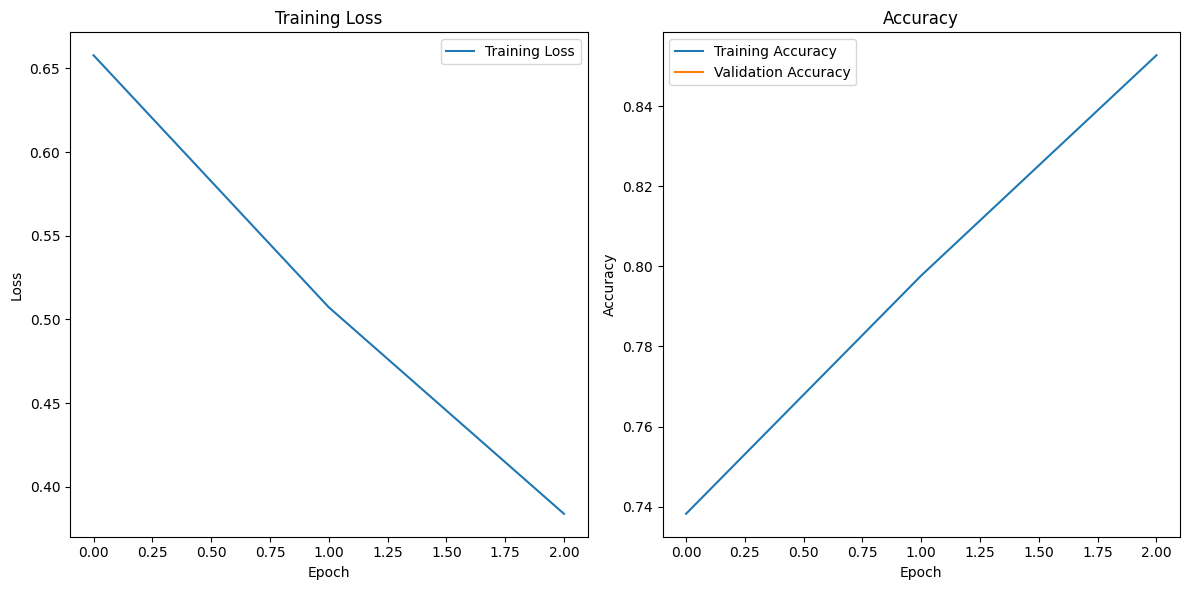

In [18]:
# Plot training and validation metrics
plt.figure(figsize=(12, 6))

# Loss
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss')
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Accuracy
plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Training Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

In [19]:
# Save the fine-tuned model
model.save_pretrained('./bert_sentiment_model')
tokenizer.save_pretrained('./bert_sentiment_model')

('./bert_sentiment_model/tokenizer_config.json',
 './bert_sentiment_model/special_tokens_map.json',
 './bert_sentiment_model/vocab.txt',
 './bert_sentiment_model/added_tokens.json')

In [20]:
# Generate classification report
all_preds = []
all_labels = []

model.eval()
with torch.no_grad():
    for batch in test_loader:
        batch = {k: v.to(device) for k, v in batch.items()}
        outputs = model(**batch)
        logits = outputs.logits
        preds = torch.argmax(logits, dim=1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(batch['labels'].cpu().numpy())

print(classification_report(all_labels, all_preds, target_names=label_encoder.classes_))

<ipython-input-11-13d551dd7bdf>:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
<ipython-input-11-13d551dd7bdf>:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item['labels'] = torch.tensor(self.labels[idx])


              precision    recall  f1-score   support

    Negative       0.77      0.80      0.78       970
     Neutral       0.34      0.25      0.29       398
    Positive       0.83      0.88      0.85      1131

    accuracy                           0.75      2499
   macro avg       0.65      0.64      0.64      2499
weighted avg       0.73      0.75      0.74      2499



In [32]:
from transformers import BertTokenizer, BertForSequenceClassification

# Load the saved model and tokenizer
model_path = './bert_sentiment_model'
model = BertForSequenceClassification.from_pretrained(model_path)
tokenizer = BertTokenizer.from_pretrained(model_path)

# Move model to the appropriate device
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model.to(device)

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e

In [33]:
def predict_sentiment(text, model, tokenizer, device):
    """
    Predicts the sentiment of a given text using the fine-tuned BERT model.

    Parameters:
    - text (str): Input text for prediction.
    - model: Fine-tuned BERT model.
    - tokenizer: Tokenizer for the model.
    - device: Device (CPU or GPU) to run the prediction.

    Returns:
    - str: Predicted sentiment (e.g., 'Positive', 'Neutral', 'Negative').
    """
    # Tokenize and encode the input text
    inputs = tokenizer(text, return_tensors="pt", truncation=True, padding=True, max_length=512)
    inputs = {key: val.to(device) for key, val in inputs.items()}

    # Perform inference
    model.eval()
    with torch.no_grad():
        outputs = model(**inputs)
        logits = outputs.logits
        predicted_class = torch.argmax(logits, dim=1).item()

    # Map predicted class to sentiment label
    sentiment_labels = ['Negative', 'Neutral', 'Positive']
    return sentiment_labels[predicted_class]


In [34]:
# Example text inputs
sample_texts = [
    "This app is amazing! I love it.",
    "The app is okay but could use some improvements.",
    "I hated this app. It's the worst experience I've had."
]

# Predict sentiment for each sample
for text in sample_texts:
    sentiment = predict_sentiment(text, model, tokenizer, device)
    print(f"Text: {text}\nPredicted Sentiment: {sentiment}\n")


Text: This app is amazing! I love it.
Predicted Sentiment: Positive

Text: The app is okay but could use some improvements.
Predicted Sentiment: Neutral

Text: I hated this app. It's the worst experience I've had.
Predicted Sentiment: Negative

